In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 

In [316]:
import functools
from time import perf_counter
import kooplearn
import numpy as np
import matplotlib.pyplot as plt
import pnstyler.styler as styler
import ml_confs

In [317]:
configs = ml_confs.from_dict({
    'train_samples': 2000,
    'test_samples': 100,
})

In [318]:
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation

In [319]:
from kooplearn.datasets import Lorenz63, LogisticMap

#raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
raw_data = LogisticMap(N=20).sample(X0 = np.ones(1), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

train_data = data[:configs.train_samples + 1]
test_data =  data[-configs.test_samples - 1:]

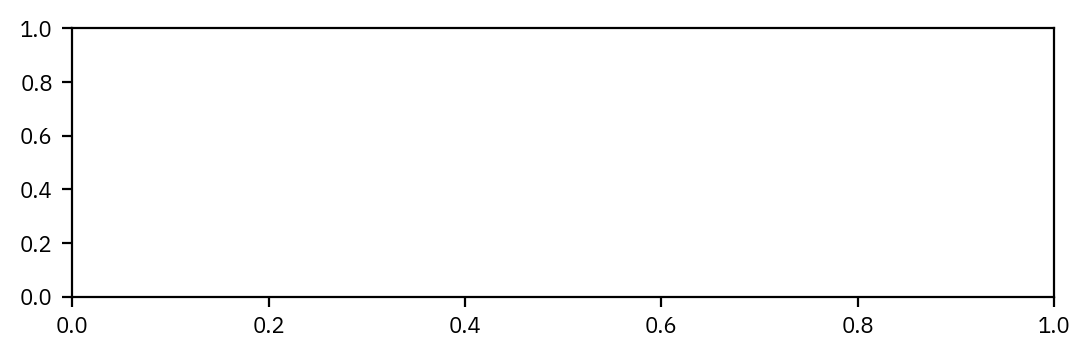

In [320]:
from itertools import combinations
fig, ax = plt.subplots(ncols=train_data.shape[1], figsize = styler.figsize(width_to_height=3), layout='tight')
for i, (x, y) in enumerate(combinations(range(train_data.shape[1]), 2)):
    ax[i].plot(data[:, x], data[:, y], lw=0.5)
    ax[i].set_xlabel(f'$x_{x}$')
    ax[i].set_ylabel(f'$x_{y}$')

## Estimator fitting

In [321]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist
from kooplearn.models import KernelDMD
from kooplearn.models.nystroem_kernel import NystroemKernelLeastSquares
from kooplearn.data import traj_to_contexts

# Length scale of the kernel: median of the pairwise distances of the dataset
data_pdist = pdist(train_data)
kernel = RBF(length_scale=np.quantile(data_pdist, 0.5))
train_contexts = traj_to_contexts(train_data)
test_contexts = traj_to_contexts(test_data)

In [355]:
reduced_rank = True
rank = 20
num_centers = 500
tikhonov_reg = 1e-6

models = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank),
    'Nystroem': NystroemKernelLeastSquares(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers)
}

In [356]:
def runner(models):
    results = {}
    for name, model in models.items():
        print(f'Running {name}')
        model, fit_time = timer(model.fit)(train_contexts, verbose=False)
        # One-step prediction
        X_pred = model.predict(test_contexts[:, :-1, ...])
        X_true = test_contexts[:, 1, ...]
        # Eigenvalues
        eigs = model.eig()

        results[name] = {
            'model': model,
            'fit_time': fit_time,
            'train_risk': model.risk(),
            'rMSE_onestep': np.sqrt(np.mean((X_pred - X_true)**2)),
            'eigenvalues': eigs,
        }
    return results
    
def hausdorff_distance(eigs_1, eigs_2):
    dist = np.abs(eigs_1[:, None] - eigs_2[None, :])
    d1 = np.min(dist, axis=1).max()
    d2 = np.min(dist, axis=0).max()
    return max(d1, d2)


In [357]:
results = runner(models)

Running KernelDMD


The fitting algorithm automatically reduced the rank of the estimator to 8. The rank attribute has been updated accordingly.


Running RandSVDKernelDMD


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:348: RuntimeWarning: divide by zero encountered in reciprocal
  vr = vr * r_normr
/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:353: RuntimeWarning: invalid value encountered in reciprocal
  vl = vl * r_norm_l


Running Nystroem


The numerical rank of the projector is smaller than the selected rank (20). 6 degrees of freedom will be ignored.
/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:348: RuntimeWarning: divide by zero encountered in reciprocal
  vr = vr * r_normr
/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:353: RuntimeWarning: invalid value encountered in reciprocal
  vl = vl * r_norm_l


In [354]:
# Print results:
for name, res in results.items():
    _str = f'''
    {name}:
        Fit time: {res["fit_time"]:.2f}s
        Train risk: {res["train_risk"]:.4e}
        One-step rMSE: {res["rMSE_onestep"]:.4e}
        Hausdorff: {hausdorff_distance(res["eigenvalues"], results["KernelDMD"]["eigenvalues"]):.2e}'''
    print(_str)


    KernelDMD:
        Fit time: 4.03s
        Train risk: 1.8133e-01
        One-step rMSE: 3.2135e-01
        Hausdorff: 0.00e+00

    RandSVDKernelDMD:
        Fit time: 0.53s
        Train risk: 1.8135e-01
        One-step rMSE: 3.2139e-01
        Hausdorff: 1.13e-01

    Nystroem:
        Fit time: 0.89s
        Train risk: 9.9703e-01
        One-step rMSE: 3.5371e-01
        Hausdorff: 9.98e-01


## Algorithms development:

In [243]:
from scipy.linalg import eig
from scipy.sparse.linalg import eigs
from kooplearn._src.operator_regression.dual import regularize
from kooplearn._src.operator_regression.utils import contexts_to_markov_train_states

model = models['KernelDMD']

X_fit, Y_fit = contexts_to_markov_train_states(model.data_fit, model.lookback_len)
kernel_X, kernel_Y, _ = model._init_kernels(X_fit, Y_fit)

dim = kernel_X.shape[0]
rsqrt_dim = dim ** (-0.5)
# Rescaled Kernel matrices
K_Xn = kernel_X * rsqrt_dim
K_Yn = kernel_Y * rsqrt_dim

K = K_Yn @ K_Xn

_num_arnoldi_eigs = min(rank + 3, K.shape[0])
eigvals = []
regs = [1, 1e-3, 1e-6, 1e-9]
for r in regs:
    eigvals.append(eigs(K, k=_num_arnoldi_eigs, M=regularize(kernel_X, r))[0])

In [273]:
from kooplearn._src.utils import topk

penalty = 1e-6
vals, vecs = eigs(K, k=_num_arnoldi_eigs, M=regularize(kernel_X, penalty))
# Filtering procedure. First: order eigenvalues by magnitude
_, sort_perm = topk(np.abs(vals), len(vals))

# Sort by magnitude
vals = vals[sort_perm]
vecs = vecs[:, sort_perm]

In [289]:
# Second: create a mask which is True when the real part of the eigenvalue is negative or the imaginary part is nonzero
is_invalid = np.logical_or(np.real(vals) < 0, np.imag(vals) != 0)
# Third, take the first occurrence of a True value in the mask and filter everything after that
first_invalid = np.argmax(is_invalid) # In the case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence are returned.
vals_filtered = vals[:first_invalid]
vecs_filtered = vecs[:, :first_invalid]
# Fourth assert that the eigenvectors do not have any imaginary part
assert np.all(np.imag(vecs_filtered) == 0)
# Fifth: take the real part of the eigenvectors
vecs_filtered = np.real(vecs_filtered)
vals_filtered = np.real(vals_filtered)
# Sixth: logging. Print the number of discarded eigenvalues, as well as the magnitude of the largest one.
print(f'Number of discarded eigenvalues: {len(vals) - len(vals_filtered)}\nLargest discarded eigenvalue: {np.max(np.abs(vals[first_invalid:])):.3e}')
# Seventh: compare the filtered eigenvalues with the regularization strength, and warn if there are any eigenvalues that are smaller than the regularization strength.
if not np.all(np.abs(vals_filtered) >= penalty):
    print(f'Warning: {(np.abs(vals_filtered) < penalty).sum()} eigenvalues are smaller than the regularization strength {penalty:.2e}, consider redudcing the regularization strength.')

Number of discarded eigenvalues: 16
Largest discarded eigenvalue: 1.135e-09


In [278]:
from kooplearn._src.linalg import weighted_norm
# Eighth: normalize the eigenvectors
M = (K_Xn @ K_Xn.T) + tikhonov_reg * kernel_X # Norm_inducing matrix
_kooplearn_norms = weighted_norm(vecs_filtered, M)

kernel_X_vecs = np.dot(K_Xn, vecs_filtered)
norm_sq = np.sum(kernel_X_vecs**2 + tikhonov_reg*kernel_X_vecs*vecs_filtered*(dim**0.5), axis=0)


/var/folders/hv/61b9_7692vs_qnbhp7fxkmfh0000gn/T/ipykernel_92646/3145804433.py:3: RuntimeWarning: invalid value encountered in matmul
  M = (K_Xn @ K_Xn.T) + tikhonov_reg * kernel_X # Norm_inducing matrix


In [314]:
%%timeit
M = (K_Xn @ K_Xn.T) + tikhonov_reg * kernel_X # Norm_inducing matrix
_kooplearn_norms = weighted_norm(vecs_filtered, M)

<magic-timeit>:1: RuntimeWarning: invalid value encountered in matmul


68.4 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [315]:
%%timeit
kernel_X_vecs = np.dot(K_Xn, vecs_filtered)
fast_norm = np.sum(kernel_X_vecs**2 + penalty*kernel_X_vecs*vecs_filtered*(dim**0.5), axis=0)**0.5

2.34 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [291]:
_kooplearn_norms

array([1.30420730e-02, 1.15862092e-03, 1.97380882e-03, 2.19908560e-04,
       1.08299035e-04, 2.06420150e-05, 2.24913431e-05])

In [ ]:
_tmp_norm = np.dot(K_Xn, vecs_filtered)
norms = 

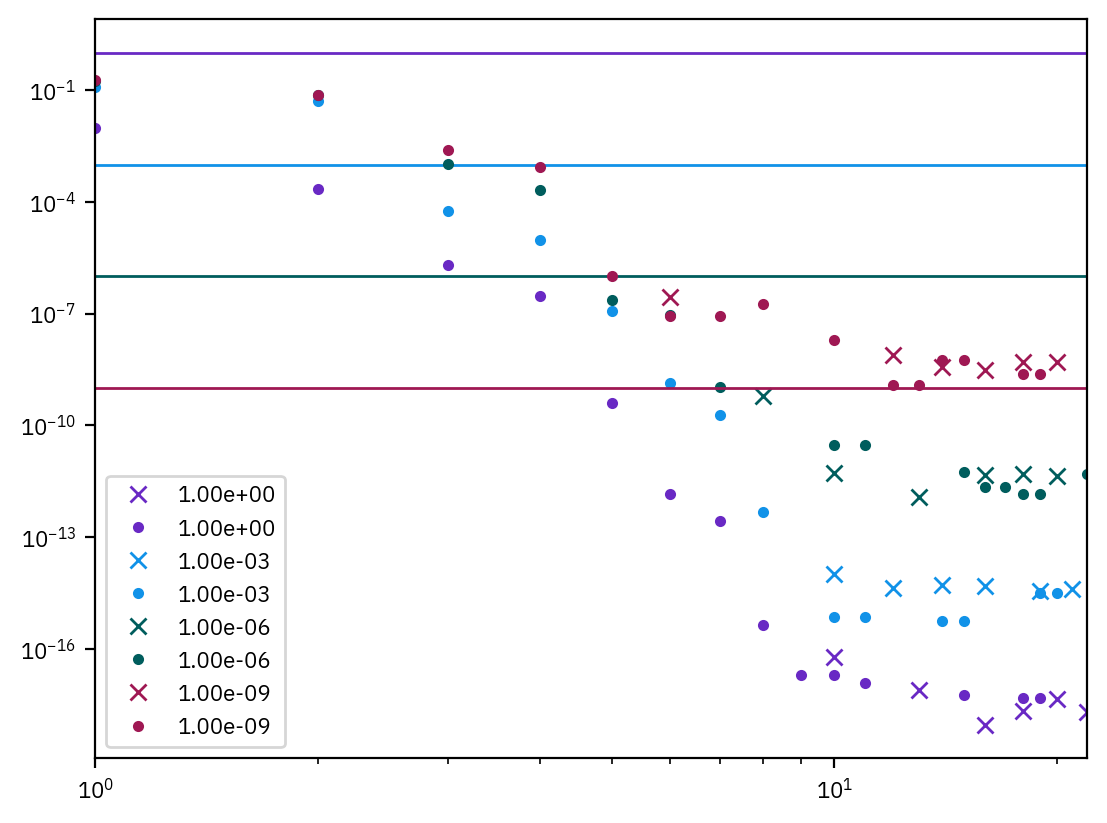

In [244]:
for i, w in enumerate(zip(eigvals, regs)):
    plt.plot(w[0].imag, 'x', label = f'{w[1]:.2e}', color=styler.palettes['categorical_light'][i])
    plt.plot(w[0].real, '.', label = f'{w[1]:.2e}', color=styler.palettes['categorical_light'][i])
    plt.axhline(w[1], color=styler.palettes['categorical_light'][i]) 
   #plt.plot(w[0].imag, '.', label = f'{w[1]:.2e}')
# plt.plot(sigma_sq_full.real, 'k.')
# plt.plot(sigma_sq_arnoldi.real, 'rx')
  
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [206]:
np.linalg.norm(kernel_X)

1324.0385853511482

array([[1.        , 0.0125394 , 0.01289618, ..., 0.71244189, 0.72511549,
        0.73039319],
       [0.0125394 , 1.        , 0.99995492, ..., 0.10218403, 0.09753344,
        0.0956339 ],
       [0.01289618, 0.99995492, 1.        , ..., 0.10427289, 0.09954774,
        0.0976174 ],
       ...,
       [0.71244189, 0.10218403, 0.10427289, ..., 1.        , 0.99976462,
        0.99952595],
       [0.72511549, 0.09753344, 0.09954774, ..., 0.99976462, 1.        ,
        0.99995863],
       [0.73039319, 0.0956339 , 0.0976174 , ..., 0.99952595, 0.99995863,
        1.        ]])

In [208]:
np.sort(eigvals[0].real)[::-1]

array([ 3.60455011e-03,  3.20472871e-04,  5.08545546e-05,  1.71724838e-05,
        1.30455121e-05,  7.34007214e-06,  1.31497585e-06,  6.79460448e-07,
        5.10752909e-07,  1.04773267e-07,  9.86711593e-08,  5.79589869e-08,
        3.13479681e-08,  1.22743646e-08,  6.41832149e-09,  4.21512477e-09,
        3.16439886e-09,  2.05329605e-09,  8.63191331e-10,  3.54268503e-10,
        3.49650919e-10,  2.63843283e-10,  1.28451661e-10,  1.01719857e-10,
        7.26371253e-11,  3.55293708e-11,  1.96316911e-11,  1.54593452e-11,
        7.97133037e-12,  7.14398976e-12,  4.89885485e-12,  2.68141660e-12,
        1.63334036e-12,  8.92488698e-13,  7.00935155e-13,  5.90233544e-13,
        4.10232519e-13,  3.03045031e-13,  1.74733446e-13,  1.10087160e-13,
        5.85608544e-14,  3.75155512e-14,  3.51000518e-14,  2.50289677e-14,
        1.60031251e-14,  1.01931598e-14,  6.84319677e-15,  4.51150331e-15,
        3.08888871e-15,  2.00720038e-15,  1.13683651e-15,  1.03540083e-15,
        8.19413588e-16,  

In [194]:
for _x in np.sort(eigvals[1].real)[::-1] / np.sort(eigvals[0].real)[::-1]:
    print(f'{_x:.2f}')

68.28
98.78
96.04
99.96
99.98
99.99
99.95
99.95
99.96
99.96
99.86
100.00
99.96
99.99
99.98
99.98
99.99
100.00
99.94
99.99
99.99
99.98
99.99
100.00
100.00
99.98
100.00
99.99
99.99
99.99
100.00
99.99
99.99
100.00
99.99
99.99
99.99
100.00
99.98
99.94
99.99
100.00
99.97
100.00
99.97
99.98
99.98
100.00
99.98
100.00
100.00
100.00
100.00


In [ ]:

max_imag_part = np.max(U.imag)
if max_imag_part >= 10.0 * U.shape[0] * np.finfo(U.dtype).eps:
    logger.warning(
        "The computed projector is not real. The Kernel matrix is severely ill-conditioned."
    )
U = np.real(U)
# Post-process U. Promote numerical stability via additional QR decoposition if necessary.
U = U[:, topk(sigma_sq.real, rank).indices]

norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X
U, _, columns_permutation = modified_QR(
    U, M=norm_inducing_op, column_pivoting=True
)
U = U[:, np.argsort(columns_permutation)]
if U.shape[1] < rank:
    logger.warning(
        f"The numerical rank of the projector is smaller than the selected rank ({rank}). {rank - U.shape[1]} "
        f"degrees of freedom will be ignored."
    )
    _zeroes = np.zeros((U.shape[0], rank - U.shape[1]))
    U = np.c_[U, _zeroes]
    assert U.shape[1] == rank
V = K_X @ np.asfortranarray(U)
if _return_singular_values:
    return U, V, sigma_sq
else:
    return U, V

## Nystroem PCR

## A better RRR

In [13]:
base_estimator = KernelDMD(kernel=kernel, reduced_rank=True, tikhonov_reg=1e-6, rank = 20, svd_solver='arnoldi')
base_estimator.fit(train_data)

Fitted KernelDMD model. Lookback length set to 1


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:69: RuntimeWarning: invalid value encountered in matmul
  norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X


In [14]:
def compare_fits(U_ref, V_ref, U_est, V_est):
    W_ref = U_ref @ V_ref.T
    W_est = U_est @ V_est.T
    return np.linalg.norm(W_ref - W_est, ord='fro') / np.linalg.norm(W_ref, ord='fro')

In [15]:
kernel_X = base_estimator.kernel_X
kernel_Y = base_estimator.kernel_Y
kernel_YX = base_estimator.kernel_YX

tikhonov_reg = 1e-3
rank = 20

In [16]:
from scipy.sparse.linalg import LinearOperator

In [ ]:
def fast_mv(x):
    

In [17]:
from kooplearn._src.operator_regression.dual import fit_reduced_rank_regression, regularize

In [59]:
from scipy.sparse import bsr_array, kron
from scipy.sparse.linalg import eigsh, aslinearoperator

def sym_rrr(
    K_X: np.ndarray,  # Kernel matrix of the input data
    K_Y: np.ndarray,  # Kernel matrix of the output data
    tikhonov_reg: float,  # Tikhonov regularization parameter, can be 0
    rank: int,  # Rank of the estimator
    svd_solver: str = "arnoldi",  # SVD solver to use. 'arnoldi' is faster but might be numerically unstable.
    _return_singular_values: bool = False
    # Whether to return the singular values of the projector. (Development purposes)
) -> tuple[np.ndarray, np.ndarray] or tuple[np.ndarray, np.ndarray, np.ndarray]:
    if tikhonov_reg == 0.0:
        raise NotImplementedError("Symmetric RRR without Tikhonov regularization is not implemented yet.")
    else:
        dim = K_X.shape[0]
        rsqrt_dim = dim ** (-0.5)
        # Rescaled Kernel matrices
        K_Xn = K_X * rsqrt_dim
        K_Yn = K_Y * rsqrt_dim

        def fast_Amv(x):
            dim = x.shape[0] // 2
            u = x[:dim]
            v = x[dim:]
            return np.r_[K_Xn @ (K_Yn @ v), K_Yn @ (K_Xn @ u)]

        def fast_Mmv(x):
            dim = x.shape[0] // 2
            u = x[:dim]
            v = x[dim:]
            reg_K = regularize(K_X, tikhonov_reg)
            return np.r_[reg_K @ v, reg_K @ u]

        A = LinearOperator((2 * dim, 2 * dim), matvec=fast_Amv)
        M = LinearOperator((2 * dim, 2 * dim), matvec=fast_Mmv)


        if svd_solver == "arnoldi":
            # Adding a small buffer to the Arnoldi-computed eigenvalues.
            _num_arnoldi_eigs = min(2*rank + 6, dim*2)
            sigma_sq, U = eigsh(A, k=_num_arnoldi_eigs, M=M)
        else:  # 'full'
            sigma_sq, U = eig(K, regularize(K_X, tikhonov_reg))

        max_imag_part = np.max(U.imag)
        if max_imag_part >= 10.0 * U.shape[0] * np.finfo(U.dtype).eps:
            logger.warning(
                "The computed projector is not real. The Kernel matrix is severely ill-conditioned."
            )
        U = np.real(U)
        # Post-process U. Promote numerical stability via additional QR decoposition if necessary.
        U = U[:, topk(sigma_sq.real, rank).indices]

        norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X
        U, _, columns_permutation = modified_QR(
            U, M=norm_inducing_op, column_pivoting=True
        )
        U = U[:, np.argsort(columns_permutation)]
        if U.shape[1] < rank:
            logger.warning(
                f"The numerical rank of the projector is smaller than the selected rank ({rank}). {rank - U.shape[1]} "
                f"degrees of freedom will be ignored."
            )
            _zeroes = np.zeros((U.shape[0], rank - U.shape[1]))
            U = np.c_[U, _zeroes]
            assert U.shape[1] == rank
        V = K_X @ np.asfortranarray(U)
        if _return_singular_values:
            return U, V, sigma_sq
        else:
            return U, V

In [22]:
from scipy.sparse import bmat, csr_array
from scipy.sparse.linalg import eigsh

In [19]:
K_X = base_estimator.kernel_X
K_Y = base_estimator.kernel_Y

dim = K_X.shape[0]
rsqrt_dim = dim ** (-0.5)
# Rescaled Kernel matrices
K_Xn = K_X * rsqrt_dim
K_Yn = K_Y * rsqrt_dim

K = K_Yn @ K_Xn
Kreg = regularize(K_X, tikhonov_reg)
# Adding a small buffer to the Arnoldi-computed eigenvalues.
# _num_arnoldi_eigs = min(2*rank + 6, dim*2)
# sigma_sq, U = eigsh(A, k=_num_arnoldi_eigs, M=M)

In [20]:
spK = csr_array(bmat([[None, K], [K.T, None]], format = 'csr'))
spKreg = csr_array(bmat([[None, Kreg], [Kreg, None]], format = 'csr'))

In [28]:
_num_arnoldi_eigs = min(6, dim*2)
sigma_sq, U = eigsh(spK, k=_num_arnoldi_eigs, M=spKreg, mode='buckling', sigma=100)

KeyboardInterrupt: 

In [24]:
sigma_sq

array([-43.28340139, -37.77323298, -35.28737111, -34.87946822,
        36.55874902,  42.06891736])

In [142]:
import matplotlib.pyplot as plt

In [143]:
plt.spy(spK)

Error in callback <function _draw_all_if_interactive at 0x28f01df80> (for post_execute):


KeyboardInterrupt: 

: 

In [15]:
np.ones((100, 5))*np.arange(5)

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1.